After concluding Phase 1, we continue with Phase 2: Training

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from typing import Tuple
from keras.utils import load_img
import keras.utils as image
from keras.models import load_model, Sequential, Model
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import random
from sklearn.utils import shuffle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_feature_maps_for_convs, encode_labels, Dataloader
from keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from keras.applications.inception_v3 import InceptionV3


tf.random.set_seed(222)

random.seed(222)

# 2. Training

First, we split our data into training, validation and test set.
Similar to the paper with the highest number of upvotes on paperswithcode [4], we split our data into 90% training, 5% validation and 5% test set [5]. As we found out before, we need to be aware of the class imbalance in the dataset. However, according to [5], we apply our data split for each of the classes separately, i.e. for each class, 90% of the samples are used for training and 5% for validation and testing, respectively. <br>
Since ~50k images is a whole lot, we also create a smaller train test validation split with 100 samples per class.

In [3]:
import pandas as pd

data = pd.read_csv("data.csv")
data = data.assign(label=data["plant"] + data["disease"])
display(data["label"].nunique())

train_small = pd.DataFrame()
test_small = pd.DataFrame()
validation_small = pd.DataFrame()

train_small = pd.DataFrame() 
train = pd.DataFrame()
test_small = pd.DataFrame()
test = pd.DataFrame()
validation_small = pd.DataFrame()
validation = pd.DataFrame()
for label in data["label"].unique():
    data_for_label = data[data["label"] == label].reset_index(drop=True)

    # small
    train_current_small = data_for_label[:90]
    validation_current_small = data_for_label[90:95]
    test_current_small = data_for_label[95:100]

    # all data
    train_current_label, rest = train_test_split(
        data_for_label, test_size=0.1
    )
    test_current_label, validation_current_label = train_test_split(
        rest, test_size=0.5
    )

    train = pd.concat([train, train_current_label])
    validation = pd.concat([validation, validation_current_label])
    test = pd.concat([test, test_current_label])
    train_small = pd.concat([train_small, train_current_small])
    validation_small = pd.concat([validation_small, validation_current_small])
    test_small = pd.concat([test_small, test_current_small])
print(
    "Sanity check for small: ",
    len(train_small) + len(test_small) + len(validation_small)
    == data["label"].nunique() * 100,
)

train = shuffle(train, random_state=42)
test = shuffle(test, random_state=42)
test.to_csv("test.csv") # save test for 3_evaluation
validation = shuffle(validation, random_state=42)
train_small = shuffle(train_small, random_state=42)
test_small = shuffle(test_small, random_state=42)
validation_small = shuffle(validation_small, random_state=42)
print("Number of samples: ", len(data))
print("Number of training samples: ", len(train))
print("Number of test samples: ", len(test))
print("Number of validation: ", len(validation))
print("Sanity check: ", len(train) + len(test) + len(validation) == len(data))

38

Sanity check for small:  True
Number of samples:  54281
Number of training samples:  48836
Number of test samples:  2716
Number of validation:  2729
Sanity check:  True


<details>
    <summary>
    GPT
    </summary>
    how do I rewrite this code to prevent from the SettingWithCopyWarning:
    Code: """
    data["label"] = data["plant"] + data["disease"]
    """
</details>

As a sanity check, we train a random forest classifier and see whether it performs better than random guessing. Since we have 38 different classes, random guessing should achieve an accuracy of roughly 1/38 (~3%) on our balanced small datasets.

In [15]:
def load_and_label_data(data: pd.DataFrame) -> Tuple:
    X, y = [], []
    for _, row in data.iterrows():
        # based on the code from the exercise
        img = load_img(row["path"], target_size=(256, 256, 3))
        img = image.img_to_array(img)
        img = img / 255
        X.append(img)
        y.append(row["label"])
    return X, y


In [21]:
X_train, y_train = load_and_label_data(train_small)
X_validation, y_validation = load_and_label_data(validation_small)
X_test, y_test = load_and_label_data(test_small)

# as discussed in the exercise, we need to flatten the data for "regular machine learning"
X_train_flat = [element.flatten() for element in X_train]
X_val_flat = [element.flatten() for element in X_validation]

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_flat, y_train)
predictions = rf.predict(X_val_flat)

print(accuracy_score(y_validation, predictions))

# release memory
del X_train_flat, X_val_flat, X_train, y_train, X_test, y_test

0.5526315789473685


An accuracy of ~0.52 appears reasonable. Next up, we try and train a convolutional neural network. The following code is mostly based on what we learned during the exercise. The goal is to overfit a model on the small training set as a sanity check.

In [22]:
encoder = OneHotEncoder(sparse_output=False)

y_train_encoded, y_validation_encoded, y_test_encoded = encode_labels(
    encoder,
    np.array(train_small["label"]).reshape(-1, 1),
    np.array(validation_small["label"]).reshape(-1, 1),
    np.array(test_small["label"]).reshape(-1, 1),
)

training_set = Dataloader(train_small["path"], y_train_encoded, 64)
test_set = Dataloader(test_small["path"], y_test_encoded, 64)
validation_set = Dataloader(validation_small["path"], y_validation_encoded, 64)

In [33]:
model = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(38, activation="softmax"),
    ]
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 32, 32, 32)     

In [26]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history = model.fit(
    training_set,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set),
    callbacks=[callback],
)

model.save("models/overfitted_sanity.h5")

Based on the training and validation results above, we conclude that the model appears to learn something from out data. Based on the divergence between training and validation accuracy, the model we assume that the model is overfitting. To verify this assumption with a visualization, let's plot the learning curve.

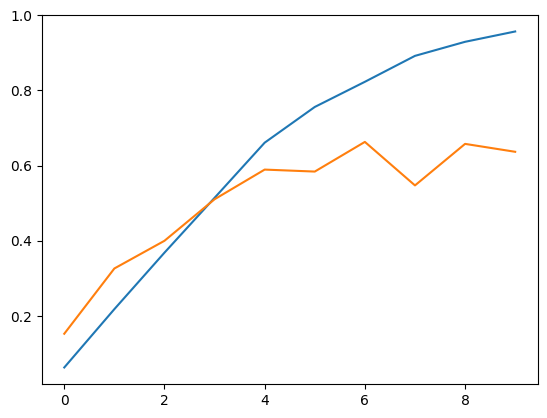

In [8]:
sns.lineplot(history.history['accuracy'])
sns.lineplot(history.history['val_accuracy'])

plt.show()

The divergence between training and validation accuracy starting approx. from epoch 4 shows that the model is actually overfitting. Thus, we consider our sanity check successful. <br>
Next, we evaluate the use of transfer learning for the task of predicting plant and disease. For this, we divide the labels of our images, such that we can train one model to predict only the plant and a second one to predict only the disease. We then use (some of) the trained weights from our first model for plant prediction in the second model for disease prediction. <br> Hereby, we need to decide whether we use the pre-trained network from the first task as a fixed feature extractor or whether it is better to fine-tune it for the second task. To make an educated guess for this decision, we train two networks for the two subtasks on our small subset of and visualize the feature maps. If the feature maps appear similar, we use the pre-trained network as a fixed feature extractor. If not, we wil fine-tune (part of) it for disease prediction.

In [16]:
encoder_plants = OneHotEncoder(sparse_output=False)
y_train_plants, y_validation_plants, y_test_plants = encode_labels(
    encoder_plants,
    np.array(train_small["plant"]).reshape(-1, 1),
    np.array(validation_small["plant"]).reshape(-1, 1),
    np.array(test_small["plant"]).reshape(-1, 1),
)

training_set_plants = Dataloader(train_small["path"], y_train_plants, 64)
validation_set_plants = Dataloader(validation_small["path"], y_validation_plants, 64)
test_set_plants = Dataloader(test_small["path"], y_validation_plants, 64)

In [34]:
model_plants = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(train_small["plant"].nunique(), activation="softmax"),
    ]
)
model_plants.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_plants.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 32, 32, 32)     

In [19]:
history = model_plants.fit(
    training_set_plants,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set_plants),
    callbacks=[callback],
)

model_plants.save("plants_small.h5")

Epoch 1/20
54/54 [==============================] - 41s 741ms/step - loss: 2.3555 - accuracy: 0.2640 - val_loss: 2.0637 - val_accuracy: 0.3263
Epoch 2/20
54/54 [==============================] - 39s 723ms/step - loss: 1.8222 - accuracy: 0.4231 - val_loss: 1.7307 - val_accuracy: 0.4421
Epoch 3/20
54/54 [==============================] - 39s 728ms/step - loss: 1.4362 - accuracy: 0.5108 - val_loss: 1.4551 - val_accuracy: 0.5105
Epoch 4/20
54/54 [==============================] - 41s 752ms/step - loss: 1.0863 - accuracy: 0.6368 - val_loss: 1.1146 - val_accuracy: 0.6737
Epoch 5/20
54/54 [==============================] - 49s 914ms/step - loss: 0.7704 - accuracy: 0.7374 - val_loss: 0.9990 - val_accuracy: 0.7105
Epoch 6/20
54/54 [==============================] - 52s 956ms/step - loss: 0.5677 - accuracy: 0.8096 - val_loss: 0.8847 - val_accuracy: 0.7368
Epoch 7/20
54/54 [==============================] - 59s 1s/step - loss: 0.3918 - accuracy: 0.8664 - val_loss: 0.9384 - val_accuracy: 0.7421
Ep

In [23]:
encoder_diseases = OneHotEncoder(sparse_output=False)
y_train_diseases, y_validation_diseases, y_test_diseases = encode_labels(
    encoder_diseases,
    np.array(train_small["disease"]).reshape(-1, 1),
    np.array(validation_small["disease"]).reshape(-1, 1),
    np.array(test_small["disease"]).reshape(-1, 1),
)

training_set_diseases = Dataloader(train_small["path"], y_train_diseases, 64)
validation_set_diseases = Dataloader(validation_small["path"], y_validation_diseases, 64)
test_set_diseases = Dataloader(test_small["path"], y_test_diseases, 64)

In [24]:
model_disease = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(21, activation="softmax"),
    ]
)
model_disease.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_disease.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 32, 32, 32)      

In [25]:
history = model_disease.fit(
    training_set_diseases,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set_diseases),
    callbacks=[callback],
)

model_disease.save("disease_small.h5")

Epoch 1/20
54/54 [==============================] - 52s 944ms/step - loss: 2.8754 - accuracy: 0.2933 - val_loss: 2.5839 - val_accuracy: 0.3158
Epoch 2/20
54/54 [==============================] - 50s 923ms/step - loss: 2.5525 - accuracy: 0.3158 - val_loss: 2.4545 - val_accuracy: 0.3158
Epoch 3/20
54/54 [==============================] - 51s 951ms/step - loss: 2.3655 - accuracy: 0.3287 - val_loss: 2.1237 - val_accuracy: 0.3579
Epoch 4/20
54/54 [==============================] - 51s 944ms/step - loss: 2.0540 - accuracy: 0.3792 - val_loss: 1.7705 - val_accuracy: 0.4421
Epoch 5/20
54/54 [==============================] - 55s 1s/step - loss: 1.7324 - accuracy: 0.4561 - val_loss: 1.4323 - val_accuracy: 0.5842
Epoch 6/20
54/54 [==============================] - 55s 1s/step - loss: 1.4463 - accuracy: 0.5327 - val_loss: 1.1336 - val_accuracy: 0.6263
Epoch 7/20
54/54 [==============================] - 51s 941ms/step - loss: 1.2253 - accuracy: 0.6009 - val_loss: 1.0134 - val_accuracy: 0.7000
Epoch

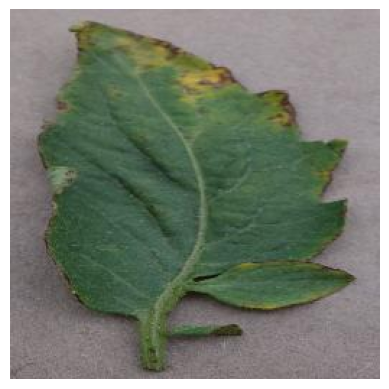

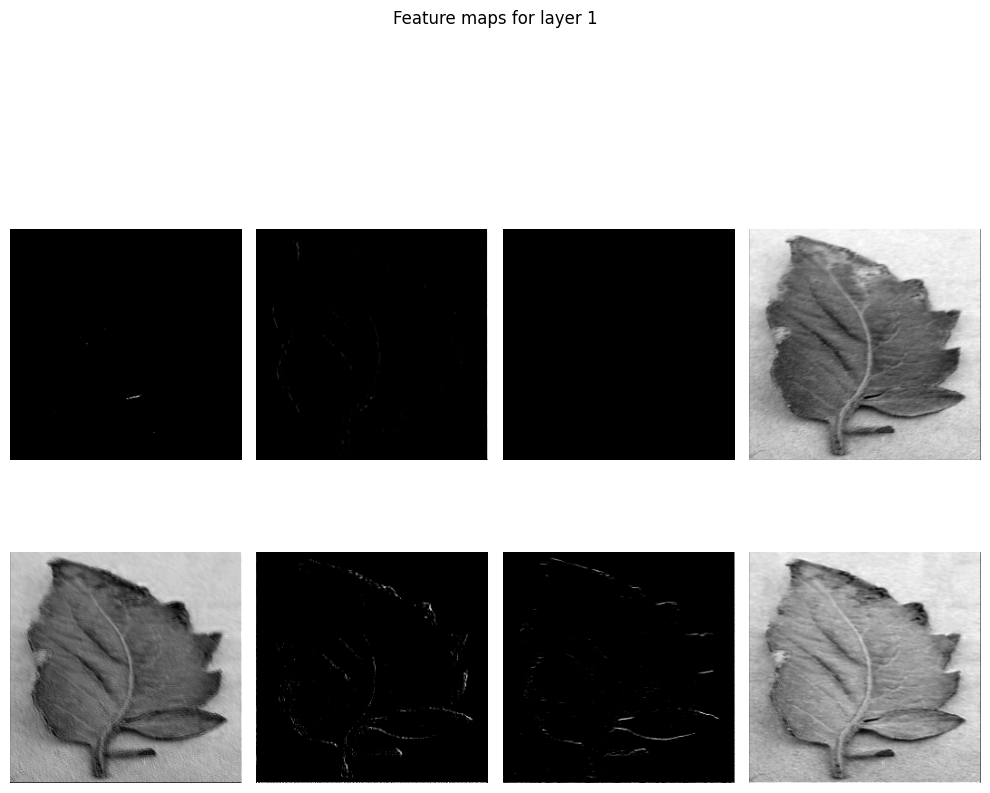

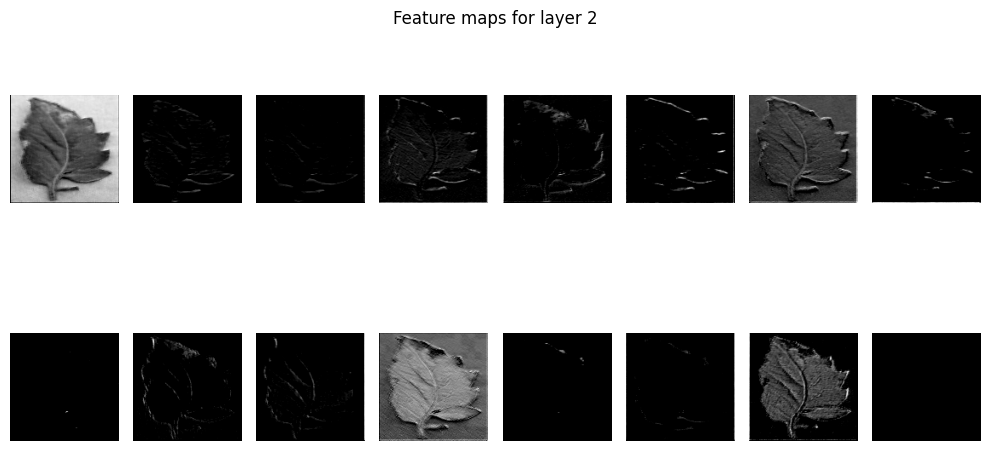

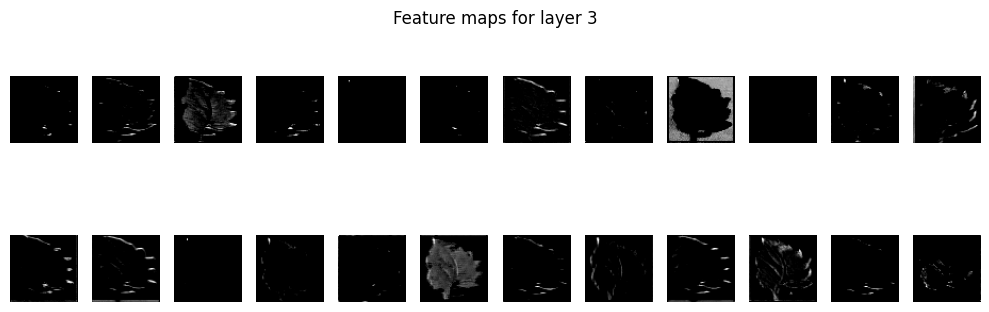

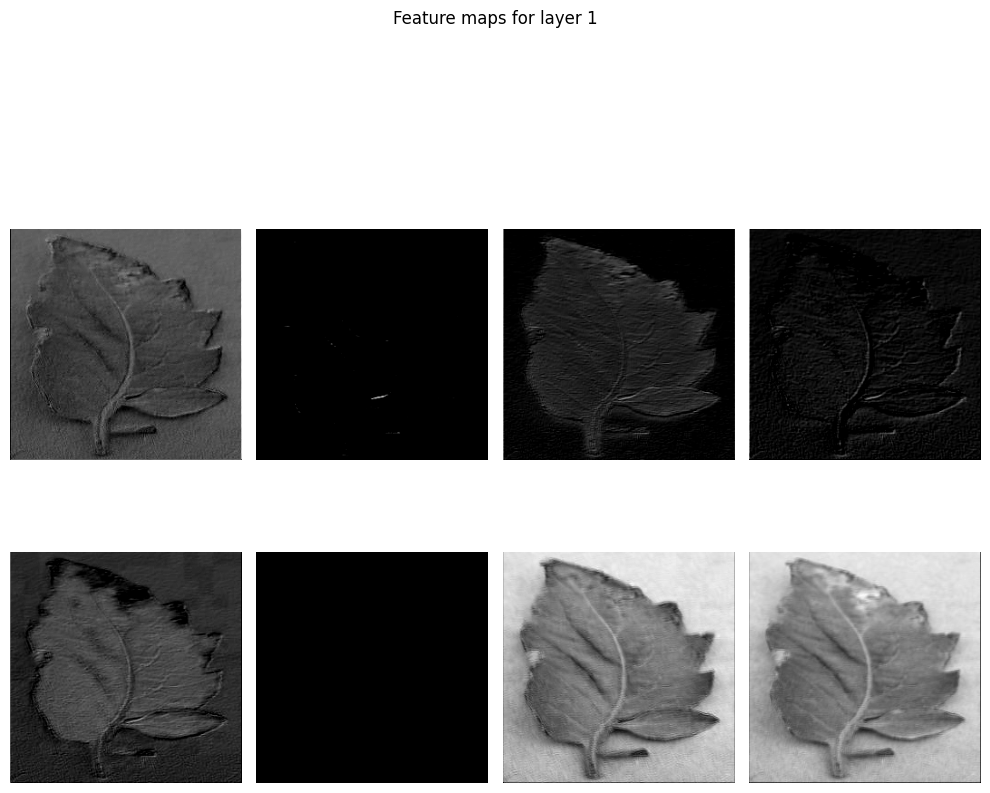

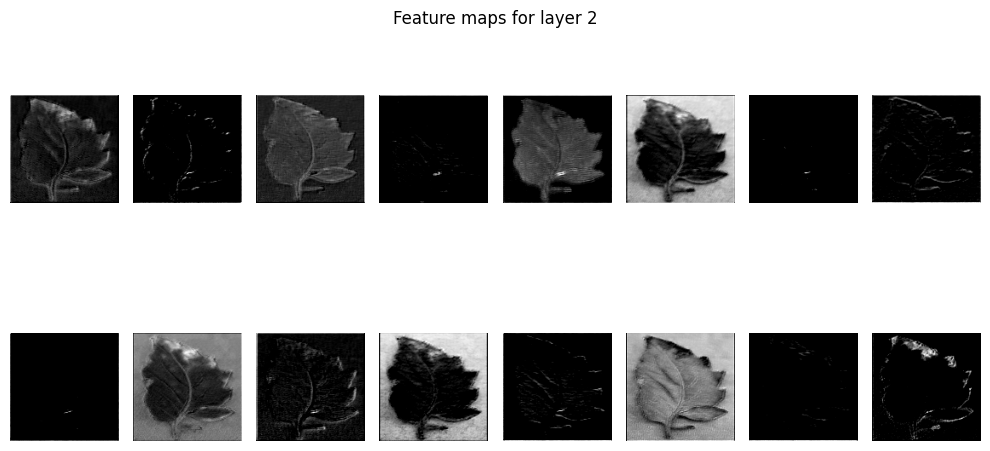

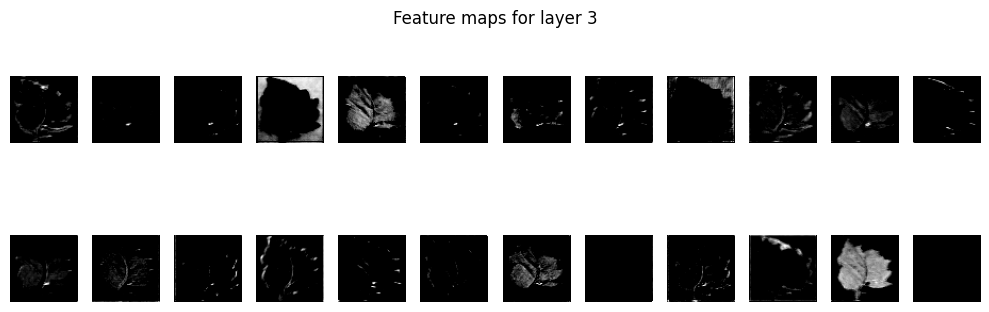

In [26]:
example_1 = test_set_plants.__getitem__(0)

# plot the sample at hand
plt.imshow(example_1[0][0])
plt.axis("off")
plt.show()

# https://stackoverflow.com/questions/67051417/how-to-predict-a-single-sample-with-keras
plot_feature_maps_for_convs(3, 8, example_1[0][0][None], model_plants)
plot_feature_maps_for_convs(3, 8, example_1[0][0][None], model_disease)

In [42]:
first_model = load_model("plants_small.h5")
first_conv_layer = first_model.layers[0]
second_conv_layer = first_model.layers[2]
first_conv_layer.trainable=False
second_conv_layer.trainable=False

transfer_model = tf.keras.models.Sequential([
    first_conv_layer,
    MaxPooling2D(2, 2),
    second_conv_layer,
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.3),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(21, activation="softmax"),
])

transfer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
transfer_model.summary()


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 32, 32, 32)     

d:\industrial_applications_of_ai\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [43]:
history = transfer_model.fit(
    training_set_diseases,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set_diseases),
    callbacks=[callback],
)

transfer_model.save("models/transfer_small.h5")

Epoch 1/20
54/54 [==============================] - 21s 367ms/step - loss: 2.7227 - accuracy: 0.2997 - val_loss: 2.5769 - val_accuracy: 0.3158
Epoch 2/20
54/54 [==============================] - 19s 348ms/step - loss: 2.5576 - accuracy: 0.3170 - val_loss: 2.4290 - val_accuracy: 0.3211
Epoch 3/20
54/54 [==============================] - 18s 335ms/step - loss: 2.4377 - accuracy: 0.3354 - val_loss: 2.2733 - val_accuracy: 0.3474
Epoch 4/20
54/54 [==============================] - 19s 349ms/step - loss: 2.3206 - accuracy: 0.3494 - val_loss: 2.1502 - val_accuracy: 0.3526
Epoch 5/20
54/54 [==============================] - 20s 376ms/step - loss: 2.1802 - accuracy: 0.3632 - val_loss: 2.0069 - val_accuracy: 0.3842
Epoch 6/20
54/54 [==============================] - 19s 351ms/step - loss: 2.0849 - accuracy: 0.3854 - val_loss: 1.8524 - val_accuracy: 0.4316
Epoch 7/20
54/54 [==============================] - 19s 344ms/step - loss: 1.9500 - accuracy: 0.4164 - val_loss: 1.6838 - val_accuracy: 0.4789

In [46]:
encoder_all = OneHotEncoder(sparse_output=False)

y_train_encoded_all, y_validation_encoded_all, y_test_encoded_all = encode_labels(
    encoder_all,
    np.array(train["label"]).reshape(-1, 1),
    np.array(validation["label"]).reshape(-1, 1),
    np.array(test["label"]).reshape(-1, 1),
)

training_set = Dataloader(train["path"], y_train_encoded_all, 64)
validation_set = Dataloader(validation["path"], y_validation_encoded_all, 64)
test_set = Dataloader(test["path"], y_test_encoded_all, 64)

48836


In [49]:
model_all = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(train_small["label"].nunique(), activation="softmax"),
    ]
)
model_all.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_all.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 32, 32, 32)     

In [50]:
history = model_all.fit(
    training_set,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set),
    callbacks=[callback],
)

model_all.save("all.h5")

Epoch 1/20
764/764 [==============================] - 722s 944ms/step - loss: 1.5738 - accuracy: 0.5520 - val_loss: 0.6620 - val_accuracy: 0.7908
Epoch 2/20
764/764 [==============================] - 600s 785ms/step - loss: 0.6757 - accuracy: 0.7920 - val_loss: 0.3919 - val_accuracy: 0.8750
Epoch 3/20
764/764 [==============================] - 596s 781ms/step - loss: 0.4444 - accuracy: 0.8596 - val_loss: 0.3146 - val_accuracy: 0.9062
Epoch 4/20
764/764 [==============================] - 594s 777ms/step - loss: 0.3173 - accuracy: 0.9004 - val_loss: 0.3046 - val_accuracy: 0.9084
Epoch 5/20
764/764 [==============================] - 602s 788ms/step - loss: 0.2324 - accuracy: 0.9258 - val_loss: 0.3081 - val_accuracy: 0.9099
Epoch 6/20
764/764 [==============================] - 603s 789ms/step - loss: 0.1973 - accuracy: 0.9378 - val_loss: 0.2274 - val_accuracy: 0.9340
Epoch 7/20
764/764 [==============================] - 605s 792ms/step - loss: 0.1615 - accuracy: 0.9501 - val_loss: 0.2517 -

In [53]:
encoder_plant_all = OneHotEncoder(sparse_output=False)

y_train_plant_all, y_validation_plant_all, y_test_plant_all = encode_labels(
    encoder_plant_all,
    np.array(train["plant"]).reshape(-1, 1),
    np.array(validation["plant"]).reshape(-1, 1),
    np.array(test["plant"]).reshape(-1, 1),
)

training_plant_set = Dataloader(train["path"], y_train_plant_all, 64)
validation_plant_set = Dataloader(validation["path"], y_validation_plant_all, 64)
test_plant_set = Dataloader(test["path"], y_test_plant_all, 64)

In [51]:
model_plant_all = Sequential(
    [
        Conv2D(
            8, (3, 3), activation="relu", input_shape=((256, 256, 3)), padding="same"
        ),
        MaxPooling2D(2, 2),
        Conv2D(16, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(train_small["plant"].nunique(), activation="softmax"),
    ]
)
model_plant_all.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_plant_all.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 32, 32, 32)     

In [54]:
history = model_plant_all.fit(
    training_plant_set,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_plant_set),
    callbacks=[callback],
)

model_plant_all.save("plant_all.h5")

Epoch 1/20
764/764 [==============================] - 803s 1s/step - loss: 0.9435 - accuracy: 0.7041 - val_loss: 0.3864 - val_accuracy: 0.8835
Epoch 2/20
764/764 [==============================] - 717s 939ms/step - loss: 0.3537 - accuracy: 0.8883 - val_loss: 0.2231 - val_accuracy: 0.9304
Epoch 3/20
764/764 [==============================] - 731s 957ms/step - loss: 0.2211 - accuracy: 0.9300 - val_loss: 0.1658 - val_accuracy: 0.9458
Epoch 4/20
764/764 [==============================] - 725s 948ms/step - loss: 0.1580 - accuracy: 0.9512 - val_loss: 0.1859 - val_accuracy: 0.9447
Epoch 5/20
764/764 [==============================] - 779s 1s/step - loss: 0.1222 - accuracy: 0.9607 - val_loss: 0.2067 - val_accuracy: 0.9436
Epoch 6/20
764/764 [==============================] - 847s 1s/step - loss: 0.0953 - accuracy: 0.9695 - val_loss: 0.1768 - val_accuracy: 0.9520


In [55]:
encoder_disease_all = OneHotEncoder(sparse_output=False)

y_train_disease_all, y_validation_disease_all, y_test_disease_all = encode_labels(
    encoder_disease_all,
    np.array(train["disease"]).reshape(-1, 1),
    np.array(validation["disease"]).reshape(-1, 1),
    np.array(test["disease"]).reshape(-1, 1),
)

training_disease_set = Dataloader(train["path"], y_train_disease_all, 64)
validation_disease_set = Dataloader(validation["path"], y_validation_disease_all, 64)
test_disease_set = Dataloader(test["path"], y_test_disease_all, 64)

In [58]:
old_plants = load_model("models/plant_all.h5")
first_conv_layer = old_plants.layers[0]
second_conv_layer = old_plants.layers[2]
first_conv_layer.trainable=False
second_conv_layer.trainable=False

model_disease_all = Sequential(
    [
        first_conv_layer
        MaxPooling2D(2, 2),
        second_conv_layer
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(64, activation="relu"),
        Dense(train_small["disease"].nunique(), activation="softmax"),
    ]
)
model_disease_all.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_disease_all.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 32, 32, 32)     

In [59]:
history = model_disease_all.fit(
    training_disease_set,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_disease_set),
    callbacks=[callback],
)

model_disease_all.save("disease_all.h5")

Epoch 1/20
764/764 [==============================] - 873s 1s/step - loss: 1.2892 - accuracy: 0.6102 - val_loss: 0.6311 - val_accuracy: 0.7988
Epoch 2/20
764/764 [==============================] - 903s 1s/step - loss: 0.5661 - accuracy: 0.8180 - val_loss: 0.3898 - val_accuracy: 0.8747
Epoch 3/20
764/764 [==============================] - 833s 1s/step - loss: 0.3678 - accuracy: 0.8793 - val_loss: 0.3564 - val_accuracy: 0.8908
Epoch 4/20
764/764 [==============================] - 996s 1s/step - loss: 0.2592 - accuracy: 0.9142 - val_loss: 0.2991 - val_accuracy: 0.9102
Epoch 5/20
764/764 [==============================] - 916s 1s/step - loss: 0.1922 - accuracy: 0.9371 - val_loss: 0.2950 - val_accuracy: 0.9128
Epoch 6/20
764/764 [==============================] - 847s 1s/step - loss: 0.1478 - accuracy: 0.9520 - val_loss: 0.3135 - val_accuracy: 0.9146
Epoch 7/20
764/764 [==============================] - 995s 1s/step - loss: 0.1204 - accuracy: 0.9616 - val_loss: 0.2634 - val_accuracy: 0.9271

In [62]:
inception = InceptionV3(include_top=False, input_shape=(256, 256, 3))
inception.trainable = False
inception.summary()

87910968/87910968 [==============================] - 15s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d_60[0][0]']              
 alization)          

In [66]:
fully_connected = Flatten()(inception.layers[-1].output)
first_dense = Dense(128, activation="relu")(fully_connected)
second_dense = Dense(64, activation="relu")(first_dense)
final = Dense(38, activation="softmax")(second_dense)

model_inception = Model(inputs = inception.inputs, outputs = final)
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_inception.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d_60[0][0]']              
 alization)                     )                                                           

 activation_1 (Activation)      (None, 125, 125, 32  0           ['batch_normalization_1[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_62 (Conv2D)             (None, 125, 125, 64  18432       ['activation_1[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 125, 125, 64  192        ['conv2d_62[0][0]']              
 rmalization)                   )                                                                 
                                                                                                  
 activation_2 (Activation)      (None, 125, 125, 64  0           ['batch_normalization_2[0][0]']  
          

In [67]:
model_inception.fit(
    training_set,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(validation_set),
    callbacks=[callback],
)

model_inception.save("inception_all.h5")

Epoch 1/20
764/764 [==============================] - 2368s 3s/step - loss: 1.1309 - accuracy: 0.7242 - val_loss: 0.5484 - val_accuracy: 0.8362
Epoch 2/20
764/764 [==============================] - 2286s 3s/step - loss: 0.3360 - accuracy: 0.8913 - val_loss: 0.3527 - val_accuracy: 0.8860
Epoch 3/20
764/764 [==============================] - 2282s 3s/step - loss: 0.2349 - accuracy: 0.9249 - val_loss: 0.4073 - val_accuracy: 0.8805
Epoch 4/20
764/764 [==============================] - 2282s 3s/step - loss: 0.1719 - accuracy: 0.9430 - val_loss: 0.4297 - val_accuracy: 0.8882
Epoch 5/20
764/764 [==============================] - 2286s 3s/step - loss: 0.1463 - accuracy: 0.9518 - val_loss: 0.4274 - val_accuracy: 0.8864


In [91]:
plant_pretrained = load_model("models/plant_all.h5")
disease_pretrained = load_model("models/disease_all.h5")

initial_cnn = plant_pretrained.layers[0].output
for layer in range(1,4):
    plant_pretrained.layers[layer].trainable=False
    initial_cnn = (plant_pretrained.layers[layer])(initial_cnn)

third_conv_layer_plant = plant_pretrained.layers[5]
third_conv_layer_disease = disease_pretrained.layers[5]

plant_branch = third_conv_layer_plant(initial_cnn)
disease_branch = third_conv_layer_disease(initial_cnn)

concat = concatenate([plant_branch, disease_branch])

flatten = Flatten()(concat)
first_dense = Dense(512, activation="relu")(flatten)
first_dropout = Dropout(0.3)(flatten)
second_dense = Dense(256, activation="relu")(first_dropout)
second_dropout = Dropout(0.3)(second_dense)
third_dense = Dense(128, activation="relu")(second_dropout)
fourth_dense = Dense(64, activation="relu")(third_dense)
activation = Dense(38, activation="softmax")(fourth_dense)
model_combined = Model(inputs = plant_pretrained.input, outputs = activation)

# as we use our pre-trained model, we slightly reduce the initial learning rate
optimizer = tf.keras.optimizers.Adam(lr=0.0001) # defaults to 0.001

model_combined.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_combined.summary()


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_51_input (InputLayer)   [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_51 (Conv2D)             (None, 256, 256, 8)  224         ['conv2d_51_input[0][0]']        
                                                                                                  
 max_pooling2d_57 (MaxPooling2D  (None, 128, 128, 8)  0          ['conv2d_51[0][0]']              
 )                                                                                                
                                                                                           

In [90]:
model_combined.fit(
    training_set,
    batch_size=64,
    epochs=30, # we grant some more epochs for training, to account for the lower learning rate
    verbose=1,
    validation_data=(validation_set),
    callbacks=[callback],
)

model.save("models/model_combined.h5")

Epoch 1/20
54/54 [==============================] - 46s 830ms/step - loss: 3.4424 - accuracy: 0.0927 - val_loss: 3.0491 - val_accuracy: 0.2211
Epoch 2/20
54/54 [==============================] - 44s 803ms/step - loss: 2.8310 - accuracy: 0.2456 - val_loss: 2.4048 - val_accuracy: 0.3579
Epoch 3/20
54/54 [==============================] - 45s 841ms/step - loss: 2.3187 - accuracy: 0.3702 - val_loss: 1.9496 - val_accuracy: 0.5105
Epoch 4/20
54/54 [==============================] - 43s 803ms/step - loss: 1.9160 - accuracy: 0.4611 - val_loss: 1.7209 - val_accuracy: 0.5316
Epoch 5/20
54/54 [==============================] - 42s 778ms/step - loss: 1.6702 - accuracy: 0.5281 - val_loss: 1.4692 - val_accuracy: 0.6316
Epoch 6/20
54/54 [==============================] - 41s 763ms/step - loss: 1.4945 - accuracy: 0.5775 - val_loss: 1.3502 - val_accuracy: 0.6316
Epoch 7/20
54/54 [==============================] - 42s 771ms/step - loss: 1.3566 - accuracy: 0.6190 - val_loss: 1.2866 - val_accuracy: 0.6579